In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

2023-05-23 19:19:08.178492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
vueltas = pd.read_csv("../dataset_todos_pilotos/vueltas_spain_final.csv")

vueltas.drop(['Piloto'], axis = 1, inplace = True)

vueltas_train = vueltas[vueltas['anyo'].isin([2018, 2019, 2020, 2021])]
vueltas_test = vueltas[vueltas['anyo'] == 2022]

#vueltas_test = vueltas_test[vueltas_test['Piloto'] == "alonso"]

vueltas_train = vueltas_train.drop(['anyo'], axis=1)
vueltas_test = vueltas_test.drop(['anyo'], axis=1)

#vueltas_train.drop(['Piloto'], axis = 1, inplace = True)
#vueltas_test.drop(['Piloto'], axis = 1, inplace = True)


vueltas_train = vueltas_train.astype(float)
vueltas_test = vueltas_test.astype(float)

In [3]:
scaler = MinMaxScaler()
scaler.fit(vueltas_train)
vueltas_train_scaler = scaler.transform(vueltas_train)
vueltas_test_scaler = scaler.transform(vueltas_test)

In [4]:
trainX = []
trainY = []
testX = []
testY = []
loopback = 10 # Esto es el numero de muestras que usara en el pasado 
future = 1 # Esto es el numero de hechos futuros que usará como salida a las 10 muestras del pasado

for i in range (loopback, len(vueltas_train_scaler) -future +1):
    trainX.append(vueltas_train_scaler[i-loopback:i, 0:vueltas_train.shape[1]])
    trainY.append(vueltas_train_scaler[i + future - 1:i + future, 5])
    #print(vueltas_train_scaler[i + future - 1:i + future, 5])
    
for i in range (loopback, len(vueltas_test_scaler) -future +1):
    testX.append(vueltas_test_scaler[i-loopback:i, 0:vueltas_test.shape[1]])
    testY.append(vueltas_test_scaler[i + future - 1:i + future,5])


In [5]:
trainX, trainY, testX, testY = np.array(trainX), np.array(trainY), np.array(testX), np.array(testY)

In [19]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer="adam", loss= "mse") ##Cambiar esto para la siguiente reunion (positivo 1, negativo 0)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 256)           283648    
                                                                 
 dropout_2 (Dropout)         (None, 10, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 480,897
Trainable params: 480,897
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
64/64 [==============================] - 5s 40ms/step - loss: 0.0279
Epoch 2/12
64/64 [==============================] - 3s 40ms/step - loss: 0.0145
Epoch 3/12
64/64 [==============================] - 3s 41ms/step - loss: 0.0128
Epoch 4/12
64/64 [==============================] - 3s 41ms/step - loss: 0.0106
Epoch 5/12
64/64 [==============================] - 3s 40ms/step - loss: 0.0101
Epoch 6/12
64/64 [==============================] - 3s 40ms/step - loss: 0.0091
Epoch 7/12
64/64 [==============================] - 3s 41ms/step - loss: 0.0087
Epoch 8/12
64/64 [==============================] - 3s 40ms/step - loss: 0.0087
Epoch 9/12
64/64 [==============================] - 3s 40ms/step - loss: 0.0088
Epoch 10/12
64/64 [==============================] - 3s 40ms/step - loss: 0.0085
Epoch 11/12
64/64 [==============================] - 3s 41ms/step - loss: 0.0086
Epoch 12/12
64/64 [==============================] - 3s 42ms/step - loss: 0.0083


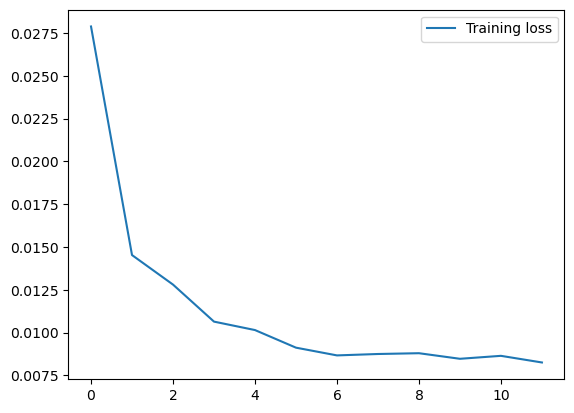

In [20]:
history = model.fit(trainX, trainY, epochs=12, batch_size=64, validation_split=0.0, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.legend()

In [21]:
clases = np.unique(trainY[:,0])
clases

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [22]:
f = lambda x: np.argwhere(x == clases)
f = np.vectorize(f)
y_real = f(testY[:,0])

In [23]:
predictions = model.predict(testX)

34/34 [==============================] - 1s 10ms/step


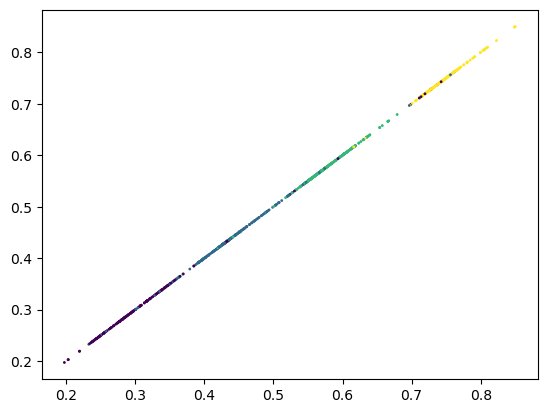

In [24]:
plt.scatter(predictions[:,0], predictions[:,0], s=1, c=y_real+1)

In [25]:
y_real_train = f(trainY[:,0])

In [26]:
predictions_train = model.predict(trainX)

128/128 [==============================] - 1s 10ms/step


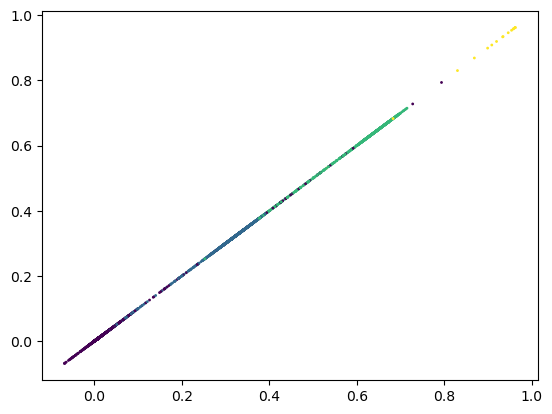

In [27]:


plt.scatter(predictions_train[:,0], predictions_train[:,0], s=1, c=y_real_train+1)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictions, y_real, test_size=0.3, stratify=y_real)

In [29]:
from sklearn.linear_model import LogisticRegression
rl = LogisticRegression(random_state=0, penalty=None).fit(X_train, y_train)

In [30]:
pred_test_2 = rl.predict(X_test)

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred_test_2))
print(classification_report(y_test, pred_test_2))

[[49  6  1  3]
 [ 3 89  6  1]
 [ 0  7 98  0]
 [ 0  0  6 51]]
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        59
           1       0.87      0.90      0.89        99
           2       0.88      0.93      0.91       105
           3       0.93      0.89      0.91        57

    accuracy                           0.90       320
   macro avg       0.91      0.89      0.90       320
weighted avg       0.90      0.90      0.90       320

